## Quick start for working with the combinatorial library

In [1]:
working_path = '/home/paula/Masterarbeit/'

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.PropertyMol import PropertyMol
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)
import pickle
import sys
from pathlib import Path

In [3]:
sys.path.append(working_path+'KinaseFocusedFragmentLibrary/kinase_focused_fragment_library/analysis/ligand_analysis')
sys.path.append(working_path+'KinaseFocusedFragmentLibrary/kinase_focused_fragment_library/recombination')
from construct_ligand import construct_ligand, read_fragment_library
from standardize import standardize_mol
from pickle_loader import pickle_loader

### Load (reduced) fragment library:

In [5]:
subpockets = ['AP', 'FP', 'SE', 'GA', 'B1', 'B2']
fragment_library = read_fragment_library(Path(working_path+'FragmentLibrary'), subpockets)

Number of fragments in AP : 230
Number of fragments in FP : 254
Number of fragments in SE : 160
Number of fragments in GA : 100
Number of fragments in B1 : 23
Number of fragments in B2 : 34


In [6]:
fragment_library.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2'])

### Load original ligands:

In [7]:
kinases_pdbs = set()
for sp in fragment_library:
    for frag in fragment_library[sp]:
        kinases_pdbs.add((frag.GetProp('kinase'), frag.GetProp('_Name')))

In [8]:
# load KLIFS ligands where those fragments originated from
klifs_ligands = []
for kinase, pdb in kinases_pdbs:
    f = working_path+'data/KLIFS_download/HUMAN/'+kinase+'/'+pdb+'/ligand.mol2'
    ligand = Chem.MolFromMol2File(f)
    ligand.SetProp('complex_pdb', pdb)
    klifs_ligands.append(ligand)

In [9]:
len(klifs_ligands)

694

## Load and work with recombined ligands:

In [22]:
combinatorial_library_folder = Path(working_path+'CombinatorialLibrary/')
file_name = combinatorial_library_folder / 'combinatorial_library.pickle'

* Perform calculations on each ligand:

In [10]:
# takes about 1-2 minutes
with open(file_name, 'rb') as pickle_file:

    for i, ligand in enumerate(pickle_loader(pickle_file)):

        # perform some calculations on each
        ligand

Reading *and* storing all ligands takes a lot of memory, therefore any calculations needed to be done on all ligands should be done within this for-loop.

* Read in a single specific ligand, e.g. with ID 3509547 (fenclozic acid):

In [11]:
with open(file_name, 'rb') as pickle_file:
    
    # fenclozic acid (approved drug): 3509547
    for i in range(3509547):
        ligand = next(pickle_loader(pickle_file))

* Read in several ligands from a given list of ligand IDs (sorted ascendingly!):

In [12]:
ligand_ids = [345, 83759, 3509547]

In [13]:
ligands = []

counter = 0
current_id = ligand_ids[counter]

with open(file_name, 'rb') as pickle_file:
    
    for i in range(max(ligand_ids)):
        ligand = next(pickle_loader(pickle_file))
        
        current_id = ligand_ids[counter]
        # store ligand corresponding to an ID in ligand_ids in list of ligands
        if i == current_id-1:
            print(current_id)
            ligands.append(ligand)
            counter += 1

345
83759
3509547


In [14]:
ligands

Example ligand for cells below: Fenclozic acid (3509547).

In [15]:
ligand = ligands[2]

* Access ligand properties:

In [16]:
vars(ligand)

{'meta': <classes_meta.Combination at 0x7fc0cd65c668>,
 'n_subpockets': 3,
 'lipinski': 1,
 'mwt': 1,
 'logp': 1,
 'hbd': 1,
 'hba': 1,
 'n_atoms': 16,
 'original': 0,
 'original_sub': 0,
 'chembl_match': 1}

In [17]:
# metadata containing information which fragments need to be connected at which bond
vars(ligand.meta)

{'frag_ids': frozenset({'AP_213', 'GA_51', 'SE_41'}),
 'bonds': frozenset({frozenset({'AP_5', 'GA_4'}),
            frozenset({'AP_6', 'SE_7'})})}

* Generate a molecule object for this ligand and standardize the molecule:

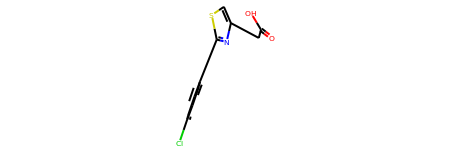

In [18]:
mol = standardize_mol(construct_ligand(ligand.meta, fragment_library))
mol

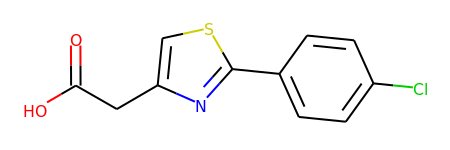

In [19]:
AllChem.Compute2DCoords(mol)
mol

* To which subpockets were the fragments assigned and from which ligands do the fragment originate?

In [20]:
highlightAtomLists = []
legends = []
for subpocket in subpockets:
    highlight_atoms = []
    legend = subpocket
    for atom in mol.GetAtoms():
        if atom.HasProp('subpocket'):
            if atom.GetProp('subpocket') == subpocket:
                highlight_atoms.append(atom.GetIdx())
                legend = subpocket + ': '+atom.GetProp('frag_id')
    highlightAtomLists.append(highlight_atoms)
    legends.append(legend)

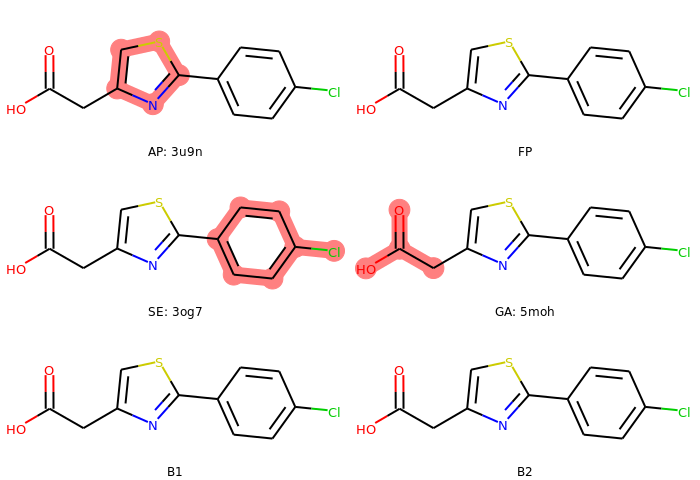

In [21]:
Draw.MolsToGridImage([mol, mol, mol, mol, mol, mol], 
                     highlightAtomLists=highlightAtomLists, legends=legends, molsPerRow=2, subImgSize=(350, 160))